In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import pandas as pd
import pymaster as nmt
import scipy.linalg as LA

In [12]:
#Settings
lmax = 2048+512
nside = 2048
freqs = ['353','545','857']

bin_size = 64

n_iter = 0

lmax_sht = 2048+1024

assert lmax_sht >= lmax

threshold = '2.5e+20_gp20'

npix = hp.nside2npix(nside)
nfreqs = len(freqs)
nspectra = nfreqs*nfreqs

In [13]:
clth = np.zeros((nfreqs,nfreqs,lmax_sht+1))
#353x353    353x545   353x857   545x545    545x857   857x857
th = np.loadtxt('../theory/cl_CIB_Lenz.txt').T
clth[0,0,1:lmax_sht+1] = th[0,0:lmax_sht]
clth[1,1,1:lmax_sht+1] = th[3,0:lmax_sht]
clth[2,2,1:lmax_sht+1] = th[5,0:lmax_sht]
clth[0,1,1:lmax_sht+1] = th[1,0:lmax_sht]
clth[1,0,1:lmax_sht+1] = th[1,0:lmax_sht]
clth[0,2,1:lmax_sht+1] = th[2,0:lmax_sht]
clth[2,0,1:lmax_sht+1] = th[2,0:lmax_sht]
clth[1,2,1:lmax_sht+1] = th[4,0:lmax_sht]
clth[2,1,1:lmax_sht+1] = th[4,0:lmax_sht]
clth[:,:,0:2] = 0.0

In [14]:
full = np.empty((nfreqs,npix))
odd = np.empty((nfreqs,npix))
even = np.empty((nfreqs,npix))
mask = np.empty((nfreqs,npix))
wl = np.empty((nfreqs,lmax_sht+1))

for ifreq, freq in enumerate(freqs):
    full[ifreq,:] = hp.read_map('../data/'+freq+'/'+threshold+'/cib_fullmission.hpx.fits')
    b = np.where(np.isnan(full[ifreq,:]))[0]
    if len(b) > 0:
        full[ifreq,b] = hp.UNSEEN
    odd[ifreq,:] = hp.read_map('../data/'+freq+'/'+threshold+'/cib_oddring.hpx.fits')
    b = np.where(np.isnan(odd[ifreq,:]))[0]
    if len(b) > 0:
        odd[ifreq,b] = hp.UNSEEN
    even[ifreq,:] = hp.read_map('../data/'+freq+'/'+threshold+'/cib_evenring.hpx.fits')
    b = np.where(np.isnan(even[ifreq,:]))[0]
    if len(b) > 0:
        even[ifreq,b] = hp.UNSEEN
    mask[ifreq,:] = hp.read_map('../data/'+freq+'/'+threshold+'/mask_apod.hpx.fits')
    b = np.where(np.isnan(mask[ifreq,:]))[0]
    if len(b) > 0:
        mask[ifreq,b] = 0
    wl[ifreq,:] = pd.read_csv('../data/'+freq+'/'+threshold+'/windowfunctions.csv',
                              comment='#',
                             )['Wl_eff'][:lmax_sht+1]

In [15]:
binning = nmt.NmtBin.from_lmax_linear(lmax, bin_size, is_Dell=False)
ell_eff = binning.get_effective_ells()
n_ell = binning.bin.n_bands
spectra = np.empty((nfreqs,nfreqs,n_ell))

In [16]:
for ifreq in range(nfreqs):
    f_1 = nmt.NmtField(mask[ifreq],[odd[ifreq]],lmax_sht=lmax_sht,beam=wl[ifreq],n_iter=n_iter)
    for jfreq in range(nfreqs):
        print('Doing ',freqs[ifreq],'x',freqs[jfreq])
        f_2 = nmt.NmtField(mask[jfreq],[even[jfreq]],lmax_sht=lmax_sht,beam=wl[jfreq],n_iter=n_iter)
        spectra[ifreq,jfreq,:] = 1e12*nmt.compute_full_master(f_1, f_2, binning,n_iter=n_iter)

Doing  353 x 353
Doing  353 x 545
Doing  353 x 857
Doing  545 x 353
Doing  545 x 545
Doing  545 x 857
Doing  857 x 353
Doing  857 x 545
Doing  857 x 857


In [17]:
noise = np.zeros((nfreqs,nfreqs,lmax_sht+1))
for ifreq in range(nfreqs):
    fsky = mask[ifreq].sum()/len(mask[ifreq])
    print(freqs[ifreq],fsky)
    f_1 = nmt.NmtField(mask[ifreq],[odd[ifreq]-even[ifreq]],lmax_sht=lmax_sht,beam=wl[ifreq],n_iter=n_iter)
    noise[ifreq,ifreq] = 1e12*nmt.compute_coupled_cell(f_1, f_1)[0]/2/fsky
noise[:,:,0:2] = 0.0

353 0.17564582831339318
545 0.1723954712226242
857 0.16546974588297492


In [18]:
clthbin = np.zeros((nfreqs,nfreqs,n_ell))
noisebin = np.zeros((nfreqs,nfreqs,n_ell))
for ifreq in range(nfreqs):
    for jfreq in range(nfreqs):
        clthbin[ifreq,jfreq] = binning.bin_cell(clth[ifreq,jfreq,0:lmax+1])
        noisebin[ifreq,jfreq] = binning.bin_cell(noise[ifreq,jfreq,0:lmax+1])

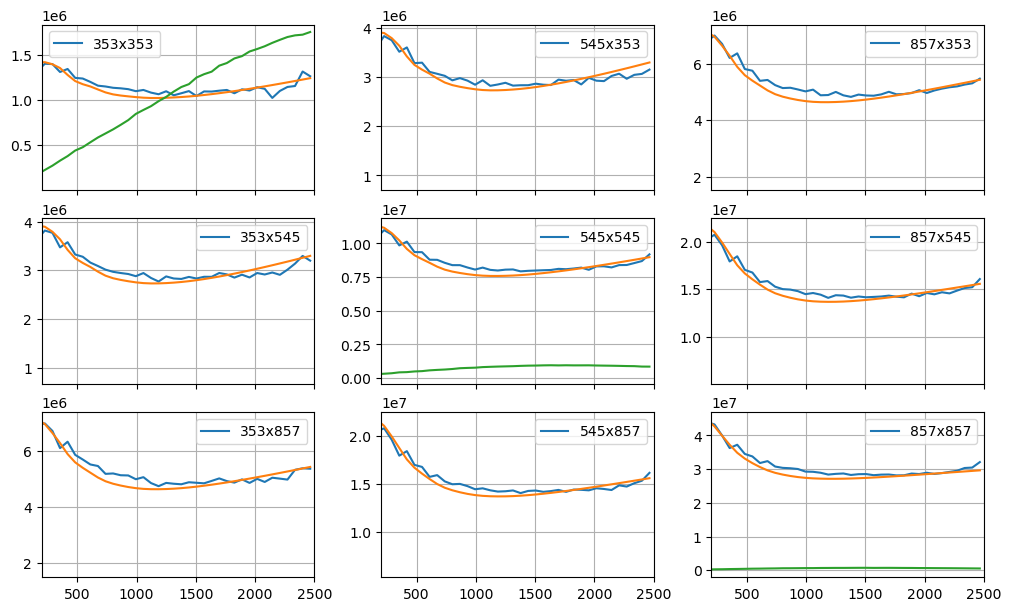

In [19]:
fig, axs = plt.subplots(3, 3, figsize=(10, 6), layout='constrained',sharex=True)
for ifreq in range(nfreqs):
    for jfreq in range(nfreqs):
        axs[jfreq,ifreq].plot(ell_eff,
                              ell_eff*spectra[ifreq,jfreq],
                              label=freqs[ifreq]+'x'+freqs[jfreq],
                             )
        axs[jfreq,ifreq].plot(ell_eff,
                              ell_eff*clthbin[ifreq,jfreq],
                             )
        axs[jfreq,ifreq].legend()
        axs[jfreq,ifreq].set_xlim(200,2500)
        axs[jfreq,ifreq].grid()
    #noise
    axs[ifreq,ifreq].plot(ell_eff,
                          ell_eff*noisebin[ifreq,ifreq],
                         )

In [21]:
covariance = np.empty((nspectra*n_ell,nspectra*n_ell))
covarianceT = np.empty((nspectra*n_ell,nspectra*n_ell))

f_0 = nmt.NmtField(mask[0],[odd[0]],lmax_sht=lmax_sht,beam=wl[0],n_iter=n_iter)
f_1 = nmt.NmtField(mask[1],[odd[1]],lmax_sht=lmax_sht,beam=wl[1],n_iter=n_iter)
f_2 = nmt.NmtField(mask[2],[odd[2]],lmax_sht=lmax_sht,beam=wl[2],n_iter=n_iter)
f_all = [f_0,f_1,f_2]

w00 = nmt.NmtWorkspace()
w00.compute_coupling_matrix(f_0, f_0, binning, n_iter=n_iter)
w01 = nmt.NmtWorkspace()
w01.compute_coupling_matrix(f_0, f_1, binning, n_iter=n_iter)
w10 = nmt.NmtWorkspace()
w10.compute_coupling_matrix(f_1, f_0, binning, n_iter=n_iter)
w02 = nmt.NmtWorkspace()
w02.compute_coupling_matrix(f_0, f_2, binning, n_iter=n_iter)
w20 = nmt.NmtWorkspace()
w20.compute_coupling_matrix(f_2, f_0, binning, n_iter=n_iter)
w11 = nmt.NmtWorkspace()
w11.compute_coupling_matrix(f_1, f_1, binning, n_iter=n_iter)
w12 = nmt.NmtWorkspace()
w12.compute_coupling_matrix(f_1, f_2, binning, n_iter=n_iter)
w21 = nmt.NmtWorkspace()
w21.compute_coupling_matrix(f_2, f_1, binning, n_iter=n_iter)
w22 = nmt.NmtWorkspace()
w22.compute_coupling_matrix(f_2, f_2, binning, n_iter=n_iter)

w_all = [[w00,w01,w02],
         [w10,w11,w12],
         [w20,w21,w22]]

isp = 0
for iodd in range(nfreqs):
    for ieven in range(nfreqs):
        jsp = 0
        for jodd in range(nfreqs):
            for jeven in range(nfreqs):
                print(isp,jsp,str(iodd)+str(ieven),str(jodd)+str(jeven))
                cw = nmt.NmtCovarianceWorkspace()
                #cla1b1,cla1b2,cla2b1,cla2b2
                #oo,oe,eo,ee
                cw.compute_coupling_coefficients(f_all[iodd],f_all[ieven],f_all[jodd],f_all[jeven], n_iter=n_iter)
                cov = nmt.gaussian_covariance(cw,
                                              0, 0, 0, 0,
                                              [clth[iodd,jodd]*wl[iodd]*wl[jodd]+noise[iodd,jodd]],
                                              [clth[iodd,jeven]*wl[iodd]*wl[jeven]],
                                              [clth[ieven,jodd]*wl[ieven]*wl[jodd]],
                                              [clth[ieven,jeven]*wl[ieven]*wl[jeven]+noise[ieven,jeven]],
                                              w_all[iodd][ieven], wb=w_all[jodd][jeven])
                
                covariance[isp*n_ell:(isp+1)*n_ell,jsp*n_ell:(jsp+1)*n_ell] = cov
                covarianceT[isp*n_ell:(isp+1)*n_ell,jsp*n_ell:(jsp+1)*n_ell] = cov.T
                jsp += 1
        isp += 1

0 0 00 00
0 1 00 01
0 2 00 02
0 3 00 10
0 4 00 11
0 5 00 12
0 6 00 20
0 7 00 21
0 8 00 22
1 0 01 00
1 1 01 01
1 2 01 02
1 3 01 10
1 4 01 11
1 5 01 12
1 6 01 20
1 7 01 21
1 8 01 22
2 0 02 00
2 1 02 01
2 2 02 02
2 3 02 10
2 4 02 11
2 5 02 12
2 6 02 20
2 7 02 21
2 8 02 22
3 0 10 00
3 1 10 01
3 2 10 02
3 3 10 10
3 4 10 11
3 5 10 12
3 6 10 20
3 7 10 21
3 8 10 22
4 0 11 00
4 1 11 01
4 2 11 02
4 3 11 10
4 4 11 11
4 5 11 12
4 6 11 20
4 7 11 21
4 8 11 22
5 0 12 00
5 1 12 01
5 2 12 02
5 3 12 10
5 4 12 11
5 5 12 12
5 6 12 20
5 7 12 21
5 8 12 22
6 0 20 00
6 1 20 01
6 2 20 02
6 3 20 10
6 4 20 11
6 5 20 12
6 6 20 20
6 7 20 21
6 8 20 22
7 0 21 00
7 1 21 01
7 2 21 02
7 3 21 10
7 4 21 11
7 5 21 12
7 6 21 20
7 7 21 21
7 8 21 22
8 0 22 00
8 1 22 01
8 2 22 02
8 3 22 10
8 4 22 11
8 5 22 12
8 6 22 20
8 7 22 21
8 8 22 22


In [22]:
sigma = np.sqrt(np.diag(covariance))
corr = covariance/np.outer(sigma,sigma)

In [23]:
sigmaT = np.sqrt(np.diag(covarianceT))
corrT = covarianceT/np.outer(sigmaT,sigmaT)

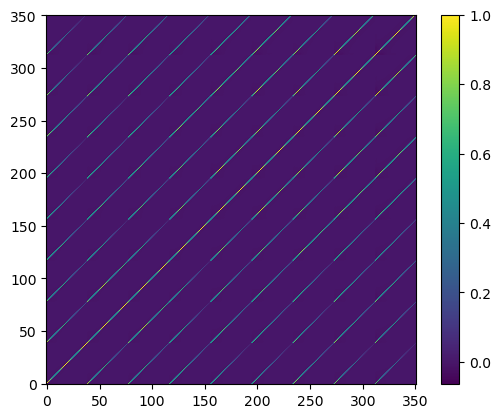

In [24]:
plt.imshow(corrT,origin='lower')
plt.colorbar()

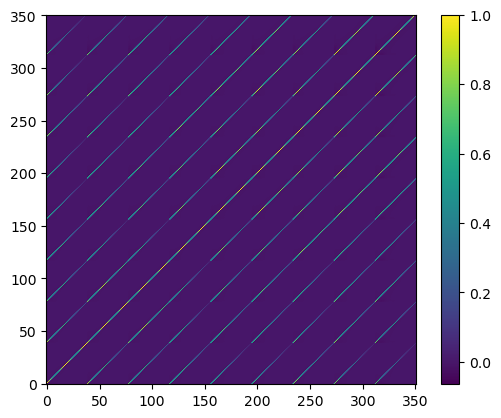

In [25]:
plt.imshow(corr,origin='lower')
plt.colorbar()

In [26]:
datavec = np.empty((nspectra*n_ell))
thvec = np.empty((nspectra*n_ell))
errors = np.empty_like(spectra)
isp=0
for ifreq in range(nfreqs):
    for jfreq in range(nfreqs):
        datavec[isp*n_ell:(isp+1)*n_ell] = spectra[ifreq,jfreq]
        thvec[isp*n_ell:(isp+1)*n_ell] = clthbin[ifreq,jfreq]
        errors[ifreq,jfreq] = sigma[isp*n_ell:(isp+1)*n_ell]
        isp+=1

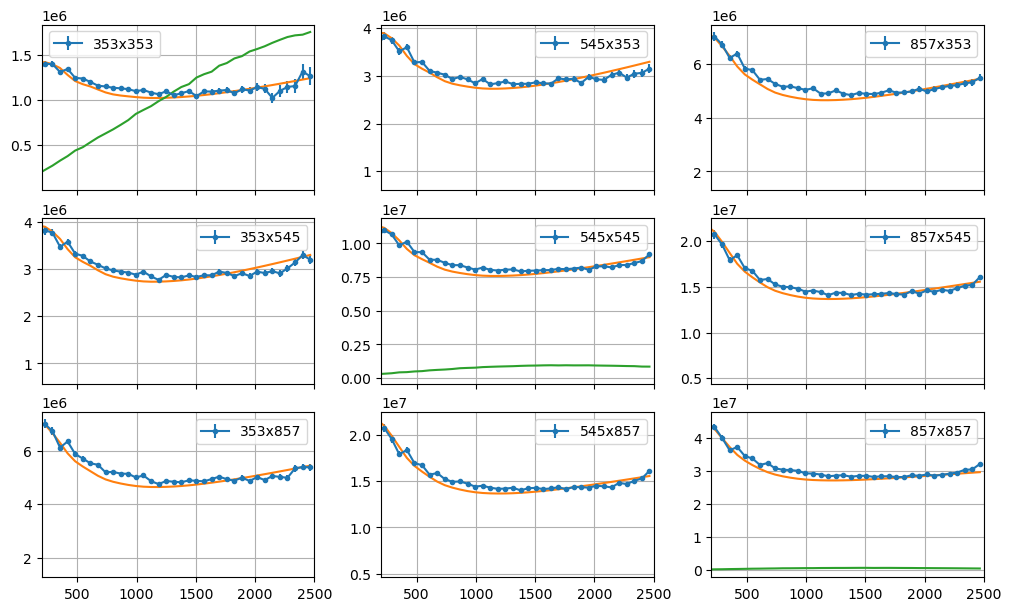

In [28]:
fig, axs = plt.subplots(3, 3, figsize=(10, 6), layout='constrained',sharex=True)
for ifreq in range(nfreqs):
    for jfreq in range(nfreqs):
        axs[jfreq,ifreq].errorbar(ell_eff,
                                  ell_eff*spectra[ifreq,jfreq],
                                  ell_eff*errors[ifreq,jfreq],
                                  label=freqs[ifreq]+'x'+freqs[jfreq],
                                  marker='.',
                                  #markersize=3,
                                  #lw=0,
                                 )
        axs[jfreq,ifreq].plot(ell_eff,
                              ell_eff*clthbin[ifreq,jfreq],
                             )
        axs[jfreq,ifreq].legend()
        axs[jfreq,ifreq].set_xlim(200,2500)
        axs[jfreq,ifreq].grid()
    #noise
    axs[ifreq,ifreq].plot(ell_eff,
                          ell_eff*binning.bin_cell(noise[ifreq,ifreq,0:lmax+1]),
                         )

In [29]:
delta = datavec-thvec
chi2full = np.dot(delta,np.dot(LA.inv(covariance),delta))
chi2diag = np.sum(delta**2/sigma**2)
print(chi2full,chi2diag)

6768.415043489093 3685.750272583311


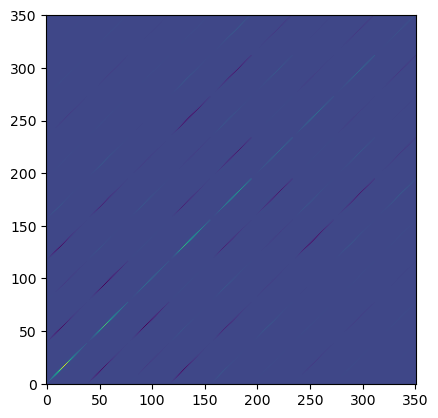

In [30]:
plt.imshow(np.linalg.inv(covariance),origin='lower')

In [31]:
LA.det(covariance)

inf

In [32]:
o = np.matmul(np.linalg.inv(covariance),covariance)

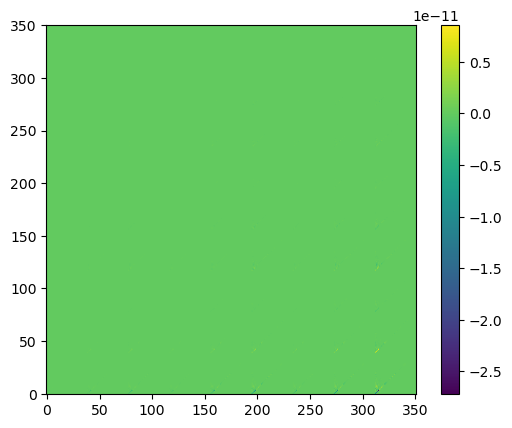

In [33]:
plt.imshow(o-np.diag(np.ones(len(sigma))),origin='lower')
plt.colorbar()

In [34]:
errors[1,1]/((clthbin[1,1]+noisebin[1,1])*np.sqrt(2/(2*ell_eff+1)/0.17/bin_size))

array([1.16203526, 1.09837788, 1.06696034, 1.05565213, 1.04873476,
       1.04353969, 1.04015529, 1.03585786, 1.03405541, 1.03145711,
       1.03026923, 1.0297654 , 1.0296783 , 1.02981831, 1.03194101,
       1.03485407, 1.03822083, 1.04283057, 1.04861433, 1.05538872,
       1.0632616 , 1.07248664, 1.08300196, 1.0946421 , 1.10855164,
       1.12364596, 1.13946165, 1.1591346 , 1.17928756, 1.20293809,
       1.23048921, 1.2582715 , 1.29120002, 1.32835039, 1.36942709,
       1.41484736, 1.46990375, 1.5194015 , 1.59055571])

In [35]:
print(np.mean(0.5*(spectra[0,1]+spectra[1,0])/np.sqrt(spectra[0,0]*spectra[1,1])))
print(np.mean(0.5*(spectra[0,2]+spectra[2,0])/np.sqrt(spectra[0,0]*spectra[2,2])))
print(np.mean(0.5*(spectra[1,2]+spectra[2,1])/np.sqrt(spectra[1,1]*spectra[2,2])))

0.968041932436683
0.8831368953095157
0.9415739541083291


In [36]:
print(np.mean(0.5*(clthbin[0,1]+clthbin[1,0])/np.sqrt(clthbin[0,0]*clthbin[1,1])))
print(np.mean(0.5*(clthbin[0,2]+clthbin[2,0])/np.sqrt(clthbin[0,0]*clthbin[2,2])))
print(np.mean(0.5*(clthbin[1,2]+clthbin[2,1])/np.sqrt(clthbin[1,1]*clthbin[2,2])))

0.9803619667040107
0.8860734238760427
0.9555416147642157


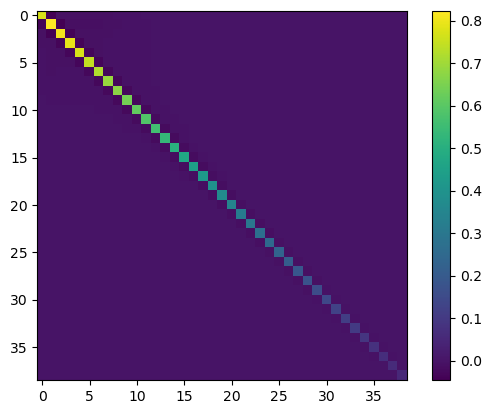

In [37]:
plt.imshow(corr[0*n_ell:1*n_ell,5*n_ell:6*n_ell])
plt.colorbar()

# Covariance only auto

In [38]:
covred=np.empty((3*n_ell,3*n_ell))
covred[0*n_ell:1*n_ell,0*n_ell:1*n_ell] = covariance[0*n_ell:1*n_ell,0*n_ell:1*n_ell]
covred[0*n_ell:1*n_ell,1*n_ell:2*n_ell] = covariance[0*n_ell:1*n_ell,4*n_ell:5*n_ell]
covred[1*n_ell:2*n_ell,0*n_ell:1*n_ell] = covariance[4*n_ell:5*n_ell,0*n_ell:1*n_ell]
covred[0*n_ell:1*n_ell,2*n_ell:3*n_ell] = covariance[0*n_ell:1*n_ell,8*n_ell:9*n_ell]
covred[2*n_ell:3*n_ell,0*n_ell:1*n_ell] = covariance[8*n_ell:9*n_ell,0*n_ell:1*n_ell]
covred[1*n_ell:2*n_ell,1*n_ell:2*n_ell] = covariance[4*n_ell:5*n_ell,4*n_ell:5*n_ell]
covred[1*n_ell:2*n_ell,2*n_ell:3*n_ell] = covariance[4*n_ell:5*n_ell,8*n_ell:9*n_ell]
covred[2*n_ell:3*n_ell,1*n_ell:2*n_ell] = covariance[8*n_ell:9*n_ell,4*n_ell:5*n_ell]
covred[2*n_ell:3*n_ell,2*n_ell:3*n_ell] = covariance[8*n_ell:9*n_ell,8*n_ell:9*n_ell]

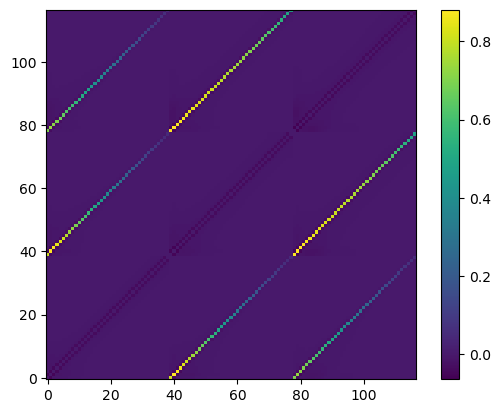

In [39]:
sigmared = np.sqrt(np.diag(covred))
corrred = covred/np.outer(sigmared,sigmared)
plt.imshow(corrred-np.diag(np.ones(len(sigmared))),origin='lower')
plt.colorbar()

In [40]:
datavecred = np.empty((3*n_ell))
thvecred = np.empty((3*n_ell))
for ifreq in range(nfreqs):
    datavecred[ifreq*n_ell:(ifreq+1)*n_ell] = spectra[ifreq,ifreq]
    thvecred[ifreq*n_ell:(ifreq+1)*n_ell] = clthbin[ifreq,ifreq]

In [41]:
deltared = datavecred-thvecred
chi2full = np.dot(deltared,np.dot(LA.inv(covred),deltared))
chi2diag = np.sum(deltared**2/sigmared**2)
print(chi2full,chi2diag)

1282.1465730108655 1624.9011633314853


In [42]:
LA.det(covred)

inf

In [43]:
np.prod(sigmared**2)

/opt/homebrew/Caskroom/miniconda/base/envs/python3.9/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


inf

# Covariance only auto 353 + 857

In [44]:
covred=np.empty((2*n_ell,2*n_ell))
covred[0*n_ell:1*n_ell,0*n_ell:1*n_ell] = covariance[0*n_ell:1*n_ell,0*n_ell:1*n_ell]
covred[0*n_ell:1*n_ell,1*n_ell:2*n_ell] = covariance[0*n_ell:1*n_ell,8*n_ell:9*n_ell]
covred[1*n_ell:2*n_ell,0*n_ell:1*n_ell] = covariance[8*n_ell:9*n_ell,0*n_ell:1*n_ell]
covred[1*n_ell:2*n_ell,1*n_ell:2*n_ell] = covariance[8*n_ell:9*n_ell,8*n_ell:9*n_ell]

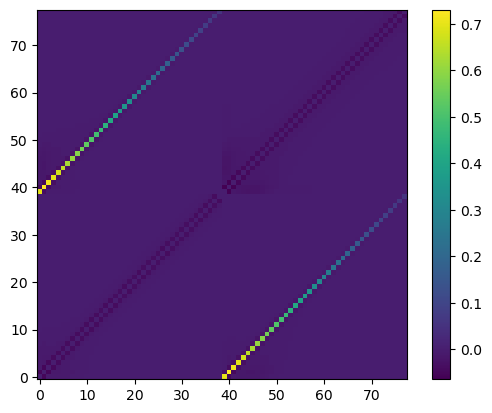

In [45]:
sigmared = np.sqrt(np.diag(covred))
corrred = covred/np.outer(sigmared,sigmared)
plt.imshow(corrred-np.diag(np.ones(len(sigmared))),origin='lower')
plt.colorbar()

In [46]:
datavecred = np.empty((2*n_ell))
thvecred = np.empty((2*n_ell))
for isp,ifreq in enumerate([0,2]):
    datavecred[isp*n_ell:(isp+1)*n_ell] = spectra[ifreq,ifreq]
    thvecred[isp*n_ell:(isp+1)*n_ell] = clthbin[ifreq,ifreq]

In [47]:
deltared = datavecred-thvecred
chi2full = np.dot(deltared,np.dot(LA.inv(covred),deltared))
chi2diag = np.sum(deltared**2/sigmared**2)
print(chi2full,chi2diag)

989.4761238495643 1053.8635835749221


In [48]:
LA.det(covred)

inf

In [49]:
np.prod(sigmared**2)

inf

# Covariance only auto 353

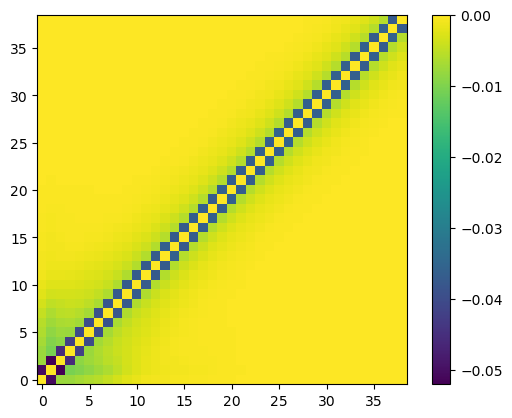

In [50]:
covred = covariance[0*n_ell:1*n_ell,0*n_ell:1*n_ell]
sigmared = np.sqrt(np.diag(covred))
corrred = covred/np.outer(sigmared,sigmared)
plt.imshow(corrred-np.diag(np.ones(len(sigmared))),origin='lower')
plt.colorbar()

In [51]:
datavecred = spectra[0,0]
thvecred = clthbin[0,0]

In [52]:
deltared = datavecred-thvecred
chi2full = np.dot(deltared,np.dot(LA.inv(covred),deltared))
chi2diag = np.sum(deltared**2/sigmared**2)
print(chi2full,chi2diag)

280.82558448183573 259.9708362644569


In [53]:
LA.det(covred)

6.557142480982588e+117

# Validation

In [56]:
nsims = 100

In [57]:
#clinth = np.zeros((6,lmax_sht+1))
#clinth[0] = clth[0,0]
#clinth[1] = clth[0,1]
#clinth[2] = clth[0,2]
#clinth[3] = clth[1,1]
#clinth[4] = clth[1,2]
#clinth[5] = clth[2,2]

#clinnoise = np.zeros((6,lmax_sht+1))
#clinnoise[0] = noise[0,0]
#clinnoise[1] = noise[0,1]
#clinnoise[2] = noise[0,2]
#clinnoise[3] = noise[1,1]
#clinnoise[4] = noise[1,2]
#clinnoise[5] = noise[2,2]
#m = nmt.synfast_spherical(nside,clinth,[0,0,0],beam=wl)
#mo = nmt.synfast_spherical(nside,clinnoise,[0,0,0])
#me = nmt.synfast_spherical(nside,clinnoise,[0,0,0])
#mo += m
#me += m

In [58]:
def generate_maps(nside,
                  cl,
                  beam,
                 ):
    l_max = len(cl[0,0])-1
    nele = hp.Alm.getsize(l_max)
    alm0 = np.zeros((nele),dtype='complex128')
    alm1 = np.zeros((nele),dtype='complex128')
    alm2 = np.zeros((nele),dtype='complex128')
    for l in range(2,l_max+1):
        r = np.random.multivariate_normal([0,0,0],cl[:,:,l],size=2*l+1)
        ind = hp.Alm.getidx(l_max,l,0)
        alm0[ind] = r[0,0]/np.sqrt(2)
        alm1[ind] = r[0,1]/np.sqrt(2)
        alm2[ind] = r[0,2]/np.sqrt(2)
        m = np.arange(1,l+1,dtype='int')
        ind = hp.Alm.getidx(l_max,l,m)
        alm0[ind] = (r[m,0]+1j*r[l+1-m,0])/np.sqrt(2)
        alm1[ind] = (r[m,1]+1j*r[l+1-m,1])/np.sqrt(2)
        alm2[ind] = (r[m,2]+1j*r[l+1-m,2])/np.sqrt(2)
    return np.column_stack(
        [hp.alm2map(hp.almxfl(alm0,beam[0]),nside),
         hp.alm2map(hp.almxfl(alm1,beam[1]),nside),
         hp.alm2map(hp.almxfl(alm2,beam[2]),nside)],
    ).T

In [59]:
m = generate_maps(nside,clth,wl)
mo = generate_maps(nside,noise,np.ones_like(wl))
me = generate_maps(nside,noise,np.ones_like(wl))
mo += m
me += m

In [60]:
f_0 = nmt.NmtField(mask[0],[m[0]],lmax_sht=lmax_sht,beam=wl[0],n_iter=n_iter)
f_1 = nmt.NmtField(mask[1],[m[1]],lmax_sht=lmax_sht,beam=wl[1],n_iter=n_iter)
f_2 = nmt.NmtField(mask[2],[m[2]],lmax_sht=lmax_sht,beam=wl[2],n_iter=n_iter)
f_all = [f_0,f_1,f_2]

In [61]:
w00 = nmt.NmtWorkspace()
w00.compute_coupling_matrix(f_0, f_0, binning, n_iter=n_iter)
w01 = nmt.NmtWorkspace()
w01.compute_coupling_matrix(f_0, f_1, binning, n_iter=n_iter)
w10 = nmt.NmtWorkspace()
w10.compute_coupling_matrix(f_1, f_0, binning, n_iter=n_iter)
w02 = nmt.NmtWorkspace()
w02.compute_coupling_matrix(f_0, f_2, binning, n_iter=n_iter)
w20 = nmt.NmtWorkspace()
w20.compute_coupling_matrix(f_2, f_0, binning, n_iter=n_iter)
w11 = nmt.NmtWorkspace()
w11.compute_coupling_matrix(f_1, f_1, binning, n_iter=n_iter)
w12 = nmt.NmtWorkspace()
w12.compute_coupling_matrix(f_1, f_2, binning, n_iter=n_iter)
w21 = nmt.NmtWorkspace()
w21.compute_coupling_matrix(f_2, f_1, binning, n_iter=n_iter)
w22 = nmt.NmtWorkspace()
w22.compute_coupling_matrix(f_2, f_2, binning, n_iter=n_iter)

In [62]:
clsims = np.empty((nsims,nspectra*n_ell))
for isim in range(nsims):
    print('Doing sim: ',isim)
#    m = nmt.synfast_spherical(nside,clinth,[0,0,0],beam=wl)
#    mo = nmt.synfast_spherical(nside,clinnoise,[0,0,0])
#    me = nmt.synfast_spherical(nside,clinnoise,[0,0,0])
#    mo += m
#    me += m
    m = generate_maps(nside,clth,wl)
    mo = generate_maps(nside,noise,np.ones_like(wl))
    me = generate_maps(nside,noise,np.ones_like(wl))
    mo += m
    me += m

    f_o_0 = nmt.NmtField(mask[0],[mo[0]],lmax_sht=lmax_sht,beam=wl[0],n_iter=n_iter)
    f_o_1 = nmt.NmtField(mask[1],[mo[1]],lmax_sht=lmax_sht,beam=wl[1],n_iter=n_iter)
    f_o_2 = nmt.NmtField(mask[2],[mo[2]],lmax_sht=lmax_sht,beam=wl[2],n_iter=n_iter)
    f_e_0 = nmt.NmtField(mask[0],[me[0]],lmax_sht=lmax_sht,beam=wl[0],n_iter=n_iter)
    f_e_1 = nmt.NmtField(mask[1],[me[1]],lmax_sht=lmax_sht,beam=wl[1],n_iter=n_iter)
    f_e_2 = nmt.NmtField(mask[2],[me[2]],lmax_sht=lmax_sht,beam=wl[2],n_iter=n_iter)    

    clsims[isim,0*n_ell:1*n_ell] = w00.decouple_cell(nmt.compute_coupled_cell(f_o_0, f_e_0))
    clsims[isim,1*n_ell:2*n_ell] = w01.decouple_cell(nmt.compute_coupled_cell(f_o_0, f_e_1))
    clsims[isim,2*n_ell:3*n_ell] = w02.decouple_cell(nmt.compute_coupled_cell(f_o_0, f_e_2))
    clsims[isim,3*n_ell:4*n_ell] = w10.decouple_cell(nmt.compute_coupled_cell(f_o_1, f_e_0))
    clsims[isim,4*n_ell:5*n_ell] = w11.decouple_cell(nmt.compute_coupled_cell(f_o_1, f_e_1))
    clsims[isim,5*n_ell:6*n_ell] = w12.decouple_cell(nmt.compute_coupled_cell(f_o_1, f_e_2))
    clsims[isim,6*n_ell:7*n_ell] = w20.decouple_cell(nmt.compute_coupled_cell(f_o_2, f_e_0))
    clsims[isim,7*n_ell:8*n_ell] = w21.decouple_cell(nmt.compute_coupled_cell(f_o_2, f_e_1))
    clsims[isim,8*n_ell:9*n_ell] = w22.decouple_cell(nmt.compute_coupled_cell(f_o_2, f_e_2))

Doing sim:  0
Doing sim:  1
Doing sim:  2
Doing sim:  3
Doing sim:  4
Doing sim:  5
Doing sim:  6
Doing sim:  7
Doing sim:  8
Doing sim:  9
Doing sim:  10
Doing sim:  11
Doing sim:  12
Doing sim:  13
Doing sim:  14
Doing sim:  15
Doing sim:  16
Doing sim:  17
Doing sim:  18
Doing sim:  19
Doing sim:  20
Doing sim:  21
Doing sim:  22
Doing sim:  23
Doing sim:  24
Doing sim:  25
Doing sim:  26
Doing sim:  27
Doing sim:  28
Doing sim:  29
Doing sim:  30
Doing sim:  31
Doing sim:  32
Doing sim:  33
Doing sim:  34
Doing sim:  35
Doing sim:  36
Doing sim:  37
Doing sim:  38
Doing sim:  39
Doing sim:  40
Doing sim:  41
Doing sim:  42
Doing sim:  43
Doing sim:  44
Doing sim:  45
Doing sim:  46
Doing sim:  47
Doing sim:  48
Doing sim:  49
Doing sim:  50
Doing sim:  51
Doing sim:  52
Doing sim:  53
Doing sim:  54
Doing sim:  55
Doing sim:  56
Doing sim:  57
Doing sim:  58
Doing sim:  59
Doing sim:  60
Doing sim:  61
Doing sim:  62
Doing sim:  63
Doing sim:  64
Doing sim:  65
Doing sim:  66
Doing

In [63]:
covsims = np.cov(clsims.T)

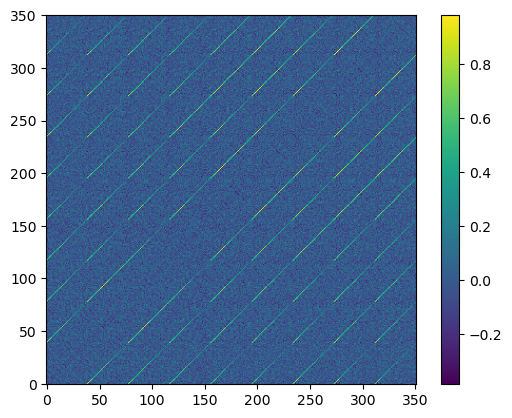

In [64]:
sigmasims = np.sqrt(np.diag(covsims))
corrsims = covsims/np.outer(sigmasims,sigmasims)
plt.imshow(corrsims-np.diag(np.ones(len(sigmasims))),origin='lower')
plt.colorbar()

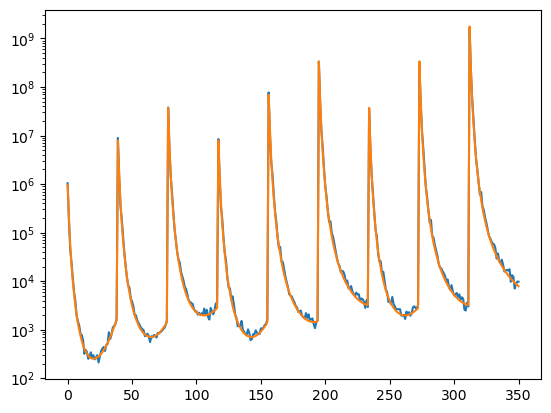

In [65]:
plt.semilogy(np.diag(covsims))
plt.semilogy(np.diag(covariance))

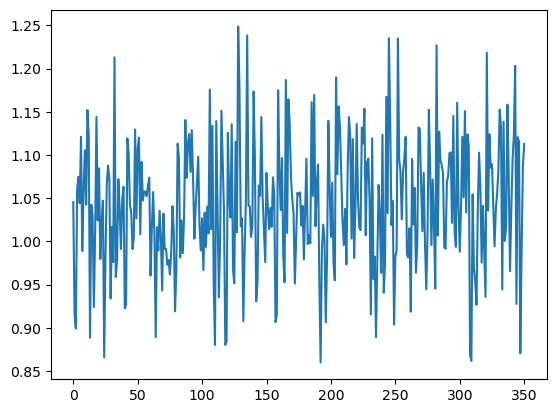

In [66]:
plt.plot(np.sqrt(np.diag(covsims)/np.diag(covariance)))

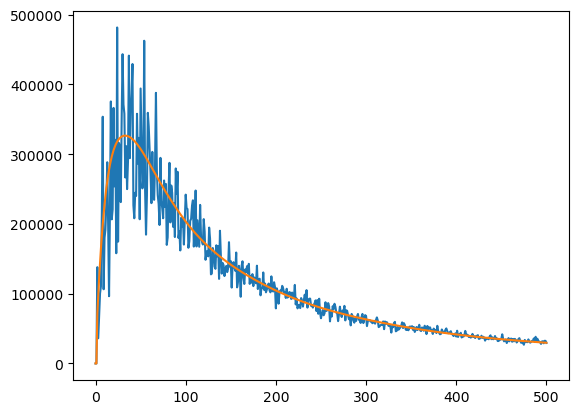

In [67]:
plt.plot(hp.anafast(m[1],m[2],lmax=500))
plt.plot(clth[1,2,0:501]*wl[1,0:501]*wl[2,0:501])

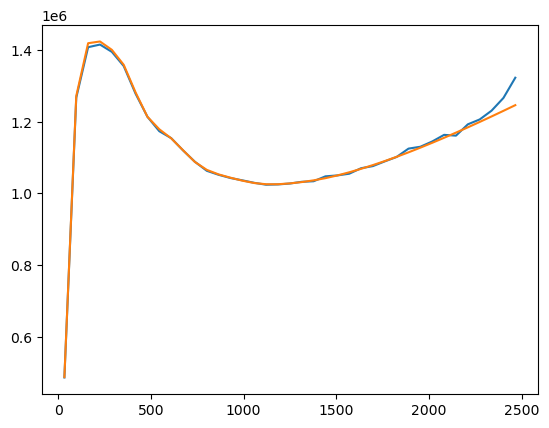

In [68]:
plt.plot(ell_eff,ell_eff*clsims.mean(axis=0)[0*n_ell:1*n_ell])
plt.plot(ell_eff,ell_eff*clthbin[0,0])

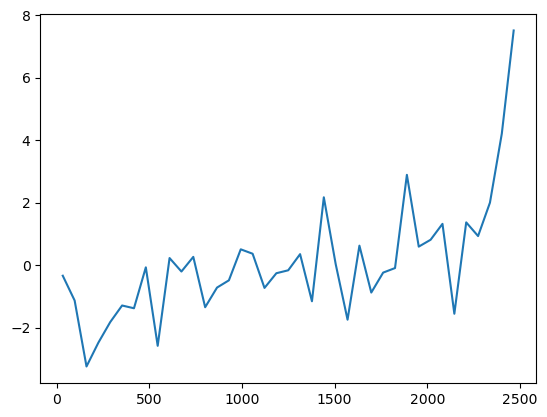

In [69]:
plt.plot(ell_eff,
         np.sqrt(nsims)*(clsims.mean(axis=0)[0*n_ell:1*n_ell]-clthbin[0,0])/clsims.std(axis=0)[0*n_ell:1*n_ell],
        )

# Save dataset full

In [70]:
# full
np.save('../outputs/'+threshold+'/spectra_full_ext.npy',spectra)
np.save('../outputs/'+threshold+'/covariance_full_ext.npy',covariance)

windows = np.zeros((n_ell,lmax+1))
for ibin in range(n_ell):
    windows[ibin,binning.get_ell_list(ibin)] = binning.get_weight_list(ibin)

np.save('../outputs/'+threshold+'/windows_full_ext.npy',windows)

f = open('../outputs/'+threshold+'/README_full_ext.txt', "w")
f.write('--CIB spectra--\n'
        'Cross spectra between odd and even maps of 353 545 857 GHz\n\n'
        'spectra_full.npy contains an array of dimension 3 x 3 x n_bins\n'
        'covariance_full.npy contains an array of dimension 9*n_bins x 9* n_bins\n\n'
        'Order\n'
        '0,0 \t o353 x e353\n'
        '0,1 \t o353 x e545\n'
        '0,2 \t o353 x e857\n'
        '1,0 \t o545 x e353\n'
        '1,1 \t o545 x e545\n'
        '1,2 \t o545 x e857\n'        
        '2,0 \t o857 x e353\n'
        '2,1 \t o857 x e545\n'
        '2,2 \t o857 x e857\n\n'
        'windows.npy contains the windows of the bandpowers in an array of dimension n_bins x lmax+1\n'
       )

f.close()

# Save dataset auto

In [71]:
# full
np.save('../outputs/'+threshold+'/spectra_auto_ext.npy',spectra)
np.save('../outputs/'+threshold+'/covariance_auto_ext.npy',covariance)

windows = np.zeros((n_ell,lmax+1))
for ibin in range(n_ell):
    windows[ibin,binning.get_ell_list(ibin)] = binning.get_weight_list(ibin)

np.save('../outputs/'+threshold+'/windows_auto_ext.npy',windows)

f = open('../outputs/'+threshold+'/README_auto_ext.txt', "w")
f.write('--CIB spectra--\n'
        'Cross spectra between odd and even maps of 353 545 857 GHz\n\n'
        'spectra_auto.npy contains an array of dimension 3 x 3 x n_bins\n'
        'covariance_auto.npy contains an array of dimension 9*n_bins x 9* n_bins\n\n'
        'Order\n'
        '0,0 \t o353 x e353\n'
        '1,1 \t o545 x e545\n'
        '1,2 \t o545 x e857\n'        
        '2,0 \t o857 x e353\n'
        '2,1 \t o857 x e545\n'
        '2,2 \t o857 x e857\n\n'
        'windows.npy contains the windows of the bandpowers in an array of dimension n_bins x lmax+1\n'
       )

f.close()